In [10]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

In [11]:
##load data

In [12]:
stock_data=pd.read_csv("F:\AAPL.csv")
stock_data.head()
stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,2023-08-11,177.320007,178.619995,176.550003,177.789993,177.789993,51988100
1253,2023-08-14,177.970001,179.690002,177.309998,179.460007,179.460007,43675600
1254,2023-08-15,178.880005,179.479996,177.050003,177.449997,177.449997,43622600
1255,2023-08-16,177.130005,178.539993,176.500000,176.570007,176.570007,46964900
1256,2023-08-17,177.139999,177.509995,173.479996,174.000000,174.000000,65956000


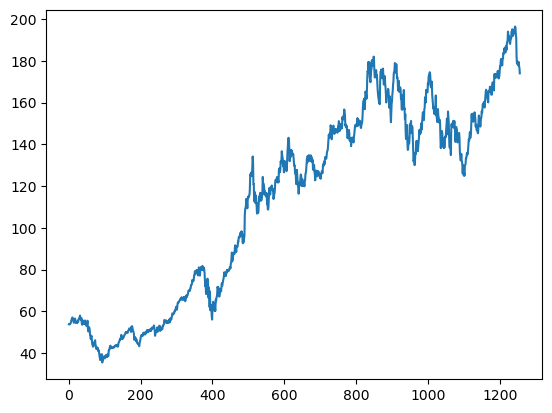

In [16]:
#close value inspection
df1 = stock_data.reset_index()['Close']
df1.shape
plt.plot(stock_data['Close']);

In [17]:
#scaling values between (0,1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
print(df1)

[[0.11384224]
 [0.11318965]
 [0.1132052 ]
 ...
 [0.88191606]
 [0.87644698]
 [0.86047453]]


In [19]:
train_len = int(len(df1)*0.80)      
#heren we are training 80 % dataset and will be used as training set
test_len = int(len(df1)-train_len) 
#test of data set is used as testing dataset

train_data = df1[0:train_len:]
test_data = df1[train_len:len(df1):1]

In [20]:
train_len,test_len

(1005, 252)

In [21]:
len(train_data),len(test_data)

(1005, 252)

In [22]:
#Dataset Matrix
def create_dataset(dataset,time_step= 1):
    dataX,dataY =[],[]
    for i in range(len(dataset)-time_step - 1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX),np.array(dataY)


In [23]:
time_step=100
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test = create_dataset(test_data,time_step)

In [24]:
print(x_train.shape, y_train.shape)
print((x_test.shape),print(y_test.shape))

(904, 100) (904,)
(151,)
(151, 100) None


In [25]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [26]:
model =Sequential()
model.add(LSTM(50,return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
15/15 [==============================] - 21s 596ms/step - loss: 0.0730 - val_loss: 0.0641
Epoch 2/50
15/15 [==============================] - 6s 376ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 3/50
15/15 [==============================] - 6s 380ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 4/50
15/15 [==============================] - 5s 358ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/50
15/15 [==============================] - 5s 366ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/50
15/15 [==============================] - 6s 367ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 7/50
15/15 [==============================] - 5s 361ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/50
15/15 [==============================] - 5s 355ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 9/50
15/15 [==============================] - 5s 359ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 10/50
15/15 [==============================] - 5s 361ms/step - loss: 0.0016 - val_loss: 0.004

In [39]:
#predicting and checcking performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

5/5 [==============================] - 0s 78ms/step


In [40]:
#transform back to original form
#because the data we have scaled down needs to be get in original
train_predict =scaler.inverse_transform(train_predict)
test_predict= scaler.inverse_transform(test_predict)

In [41]:
import math
from sklearn.metrics import mean_squared_error

In [42]:
#calculate RMSE performance metrics for train data
math.sqrt(mean_squared_error(y_train,train_predict))

115.10193227560559

In [43]:
#test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

165.4340596593235

In [44]:
#shift train prediction for plotting
look_back=100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, : ] = train_predict

In [45]:
#shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1 : len(df1)-1, :]= test_predict

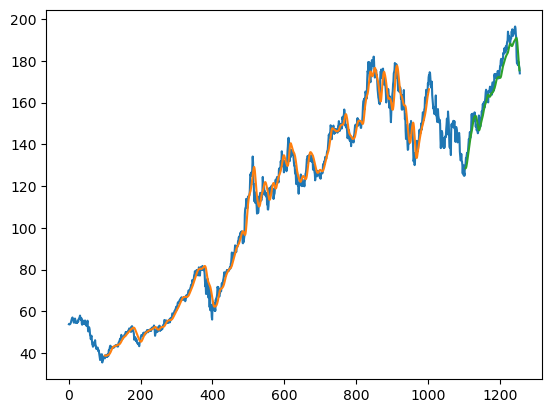

In [46]:
#plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [37]:
len(test_data)

252

In [47]:
## to predict the price after 100 days 252-100=152 days

In [48]:
x_input = test_data[152:].reshape(1,-1)
x_input.shape


(1, 100)

In [49]:
temp_input=list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.7627756004481125,
 0.7588601546616158,
 0.7782508420503309,
 0.7881325843447453,
 0.8039184985669832,
 0.8118115022901822,
 0.8084554760418385,
 0.7968334686368075,
 0.8024269741595558,
 0.7860816403991646,
 0.7784372841549954,
 0.7740868420089644,
 0.8080203864581443,
 0.8058452119972086,
 0.8059694425125639,
 0.8136760041310982,
 0.820885364015733,
 0.8147946505441408,
 0.8046643539948568,
 0.8065909742009225,
 0.7968956740111728,
 0.7968334686368075,
 0.8257330141106078,
 0.8336259246096469,
 0.8330665982956538,
 0.8265408884645271,
 0.8197666243785307,
 0.8094497925004223,
 0.8578021437280876,
 0.8573670541443932,
 0.8466152259067505,
 0.8577399383537221,
 0.85892079014113,
 0.8515871997411404,
 0.8484797277476668,
 0.8484797277476668,
 0.8523329619448539,
 0.8670002359689934,
 0.8676838860225016,
 0.8617174962904244,
 0.8453100503798276,
 0.847050222266285,
 0.8541974637857701,
 0.8693618525345934,
 0.8809838599396247,
 0.8806730940954455,
 0.8983235101585996,
 0.90366836820231

In [50]:
lst_output =[]
n_steps =100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape(1,n_steps,1)
        yhat = model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape(1,n_steps,1)
        yhat = model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

[0.85637236]
101
1 day input [0.75886015 0.77825084 0.78813258 0.8039185  0.8118115  0.80845548
 0.79683347 0.80242697 0.78608164 0.77843728 0.77408684 0.80802039
 0.80584521 0.80596944 0.813676   0.82088536 0.81479465 0.80466435
 0.80659097 0.79689567 0.79683347 0.82573301 0.83362592 0.8330666
 0.82654089 0.81976662 0.80944979 0.85780214 0.85736705 0.84661523
 0.85773994 0.85892079 0.8515872  0.84847973 0.84847973 0.85233296
 0.86700024 0.86768389 0.8617175  0.84531005 0.84705022 0.85419746
 0.86936185 0.88098386 0.88067309 0.89832351 0.90366837 0.89515393
 0.89285443 0.88421566 0.90130675 0.90373058 0.92131878 0.91833564
 0.9223132  0.93511597 0.9283417  0.92890103 0.92237541 0.9412688
 0.93927997 0.93051697 0.94785663 0.95525242 0.95736548 0.98458696
 0.97520244 0.96817952 0.97116267 0.96413975 0.95127486 0.94798095
 0.95848422 0.96326966 0.96420195 0.98471129 0.98309535 0.99160988
 0.97936644 0.97197063 0.97700473 0.9824117  0.98788088 0.97992576
 0.99614677 1.         0.99477947 0

8 day output [[0.83632976]]
9 day input [0.78608164 0.77843728 0.77408684 0.80802039 0.80584521 0.80596944
 0.813676   0.82088536 0.81479465 0.80466435 0.80659097 0.79689567
 0.79683347 0.82573301 0.83362592 0.8330666  0.82654089 0.81976662
 0.80944979 0.85780214 0.85736705 0.84661523 0.85773994 0.85892079
 0.8515872  0.84847973 0.84847973 0.85233296 0.86700024 0.86768389
 0.8617175  0.84531005 0.84705022 0.85419746 0.86936185 0.88098386
 0.88067309 0.89832351 0.90366837 0.89515393 0.89285443 0.88421566
 0.90130675 0.90373058 0.92131878 0.91833564 0.9223132  0.93511597
 0.9283417  0.92890103 0.92237541 0.9412688  0.93927997 0.93051697
 0.94785663 0.95525242 0.95736548 0.98458696 0.97520244 0.96817952
 0.97116267 0.96413975 0.95127486 0.94798095 0.95848422 0.96326966
 0.96420195 0.98471129 0.98309535 0.99160988 0.97936644 0.97197063
 0.97700473 0.9824117  0.98788088 0.97992576 0.99614677 1.
 0.99477947 0.9759482  0.9671851  0.91013196 0.89061704 0.89652122
 0.88651515 0.88514786 0.88402

16 day output [[0.8272262]]
17 day input [0.81479465 0.80466435 0.80659097 0.79689567 0.79683347 0.82573301
 0.83362592 0.8330666  0.82654089 0.81976662 0.80944979 0.85780214
 0.85736705 0.84661523 0.85773994 0.85892079 0.8515872  0.84847973
 0.84847973 0.85233296 0.86700024 0.86768389 0.8617175  0.84531005
 0.84705022 0.85419746 0.86936185 0.88098386 0.88067309 0.89832351
 0.90366837 0.89515393 0.89285443 0.88421566 0.90130675 0.90373058
 0.92131878 0.91833564 0.9223132  0.93511597 0.9283417  0.92890103
 0.92237541 0.9412688  0.93927997 0.93051697 0.94785663 0.95525242
 0.95736548 0.98458696 0.97520244 0.96817952 0.97116267 0.96413975
 0.95127486 0.94798095 0.95848422 0.96326966 0.96420195 0.98471129
 0.98309535 0.99160988 0.97936644 0.97197063 0.97700473 0.9824117
 0.98788088 0.97992576 0.99614677 1.         0.99477947 0.9759482
 0.9671851  0.91013196 0.89061704 0.89652122 0.88651515 0.88514786
 0.88402912 0.89440816 0.88191606 0.87644698 0.86047453 0.85637236
 0.85210007 0.84876889 

25 day output [[0.81916815]]
26 day input [0.81976662 0.80944979 0.85780214 0.85736705 0.84661523 0.85773994
 0.85892079 0.8515872  0.84847973 0.84847973 0.85233296 0.86700024
 0.86768389 0.8617175  0.84531005 0.84705022 0.85419746 0.86936185
 0.88098386 0.88067309 0.89832351 0.90366837 0.89515393 0.89285443
 0.88421566 0.90130675 0.90373058 0.92131878 0.91833564 0.9223132
 0.93511597 0.9283417  0.92890103 0.92237541 0.9412688  0.93927997
 0.93051697 0.94785663 0.95525242 0.95736548 0.98458696 0.97520244
 0.96817952 0.97116267 0.96413975 0.95127486 0.94798095 0.95848422
 0.96326966 0.96420195 0.98471129 0.98309535 0.99160988 0.97936644
 0.97197063 0.97700473 0.9824117  0.98788088 0.97992576 0.99614677
 1.         0.99477947 0.9759482  0.9671851  0.91013196 0.89061704
 0.89652122 0.88651515 0.88514786 0.88402912 0.89440816 0.88191606
 0.87644698 0.86047453 0.85637236 0.85210007 0.84876889 0.84604305
 0.84370112 0.84161103 0.83970374 0.83794767 0.83632976 0.8348437
 0.83348376 0.83223939

In [51]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [52]:
len(df1)

1257

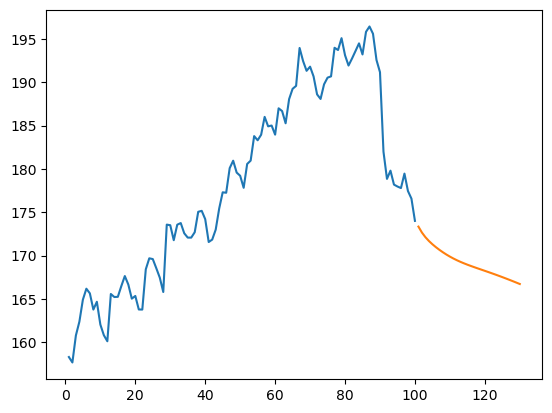

In [53]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]));
plt.plot(day_pred,scaler.inverse_transform(lst_output));

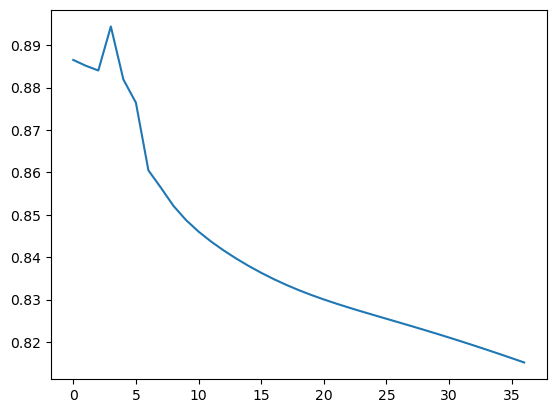

In [54]:
df3= df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1250:]);